In [ ]:
# https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# from sklearn.externals import joblib
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

In [57]:
import pandas as pd
import numpy as np

wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
wine_data = pd.read_csv(wine_url, header=None)
wine_data.columns = ['class', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium',
                     'total phenols', 'flavonoids', 'nonflavonoid phenols', 'proanthocyanidins',
                     'color intensity', 'hue', 'OD280/0D315 of diluted wines', 'proline']
wine_data['class'] = wine_data['class'].astype('category')

# Normalizing 'alcohol' column in the wine_data using Min-Max normalization
wine_data['alcohol']= (wine_data['alcohol'] - wine_data['alcohol'].min()) / (wine_data['alcohol'].max()- wine_data['alcohol'].min())



wine_quality_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_quality_data = pd.read_csv (wine_quality_url, sep=";")

# Creating an average quality column in wine_quality_data
wine_quality_data['average_quality'] = wine_quality_data[['fixed acidity', 'volatile acidity', 'citric acid',
                                                          'residual sugar', 'chlorides', 'free sulfur dioxide',
                                                          'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']].mean(axis = 1)

# Creating a 'quality_label' column based on average_quality'
wine_quality_data['quality_label'] = pd.cut(wine_quality_data['average_quality'], bins = [0, 5, 7, np.inf], 
                                            labels = ['low', 'medium', 'high'])


In [58]:
wine_quality_data.tail(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,average_quality,quality_label
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,9.110497,high
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6,7.862954,high


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns 

# Checking for distributions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(12,12))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

In [51]:
wine_quality_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
 12  average_quality       1599 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 162.5 KB


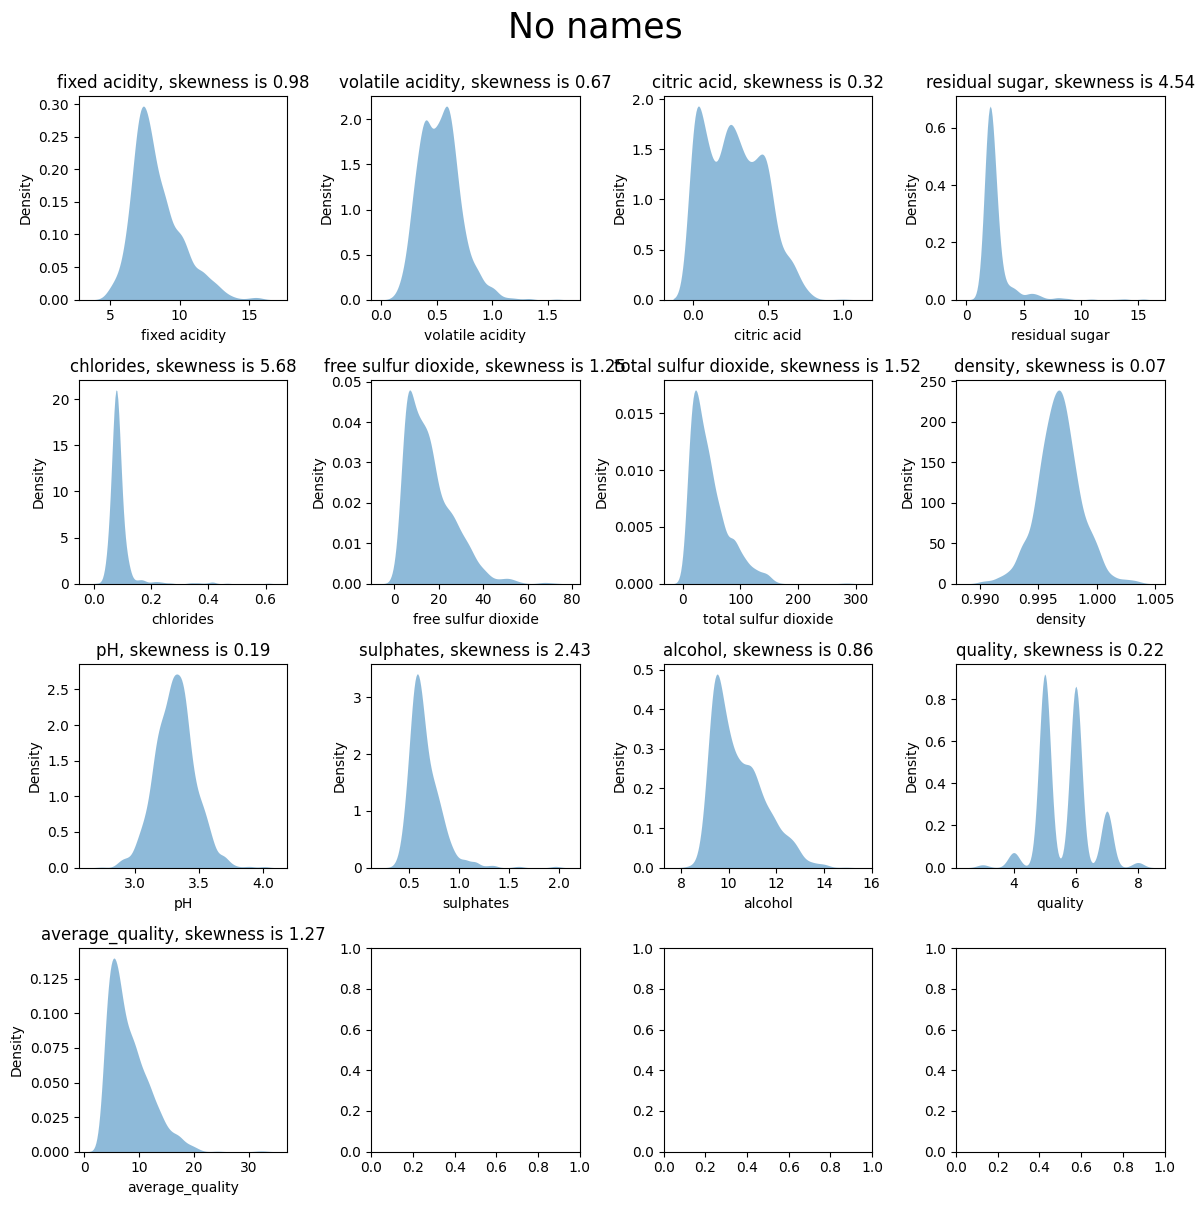

In [59]:
# wine_quality_data.drop('quality_label', axis=1, inplace=True)
dist_custom(dataset=wine_quality_data[wine_quality_data.columns[:-1]], columns_list=wine_quality_data.columns[:-1], rows=4, cols=4, suptitle='No names')
plt.tight_layout()
plt.show()

In [60]:
X = np.array(wine_quality_data[wine_quality_data.columns[:-1]])
y = np.array(wine_quality_data[wine_quality_data.columns[-1]])

### 1.기본 포멧

In [64]:
# Load and split the data
# iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
pipe_dt = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]
			
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
	pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
	print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved [%s] pipeline to file' % pipe_dict[best_clf])

Logistic Regression pipeline test accuracy: 0.709
Support Vector Machine pipeline test accuracy: 0.750
Decision Tree pipeline test accuracy: 0.778
Classifier with best accuracy: Decision Tree
Saved [Decision Tree] pipeline to file


In [63]:
pipe

Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', DecisionTreeClassifier(random_state=42))])

### 2.GridSearchCV 추가(metaparameter tunning)

In [65]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Load and split the data
# iris = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct pipeline
pipe = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', tree.DecisionTreeClassifier(random_state=42))])

param_range = [1, 2, 3, 4, 5]

# Set grid search params
grid_params = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:],
		# 'clf__presort': [True, False]
		}]

# Construct grid search
gs = GridSearchCV(estimator=pipe,
			param_grid=grid_params,
			scoring='accuracy',
			cv=10)

# Fit using grid search
gs.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best accuracy: 0.777

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}


In [19]:
gs

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid=[{'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [1, 2, 3, 4, 5],
                          'clf__min_samples_leaf': [1, 2, 3, 4, 5],
                          'clf__min_samples_split': [2, 3, 4, 5]}],
             scoring='accuracy')

### 3.최적모형 선별

In [67]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# from sklearn.externals import joblib
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Load and split the data
# iris = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', svm.SVC(random_state=42))])
			
# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range,
		'clf__max_depth': param_range,
		'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Random Forest', 3: 'Random Forest w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	gs.fit(X_train, y_train)
	# Best params
	print('Best params: %s' % gs.best_params_)
	# Best training data accuracy
	print('Best training accuracy: %.3f' % gs.best_score_)
	# Predict on test data with best params
	y_pred = gs.predict(X_test)
	# Test data accuracy of model with best params
	print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
	# Track best (highest test accuracy) model
	if accuracy_score(y_test, y_pred) > best_acc:
		best_acc = accuracy_score(y_test, y_pred)
		best_gs = gs
		best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression


c:\Users\khpark\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [22]:
gs

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('clf', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'clf__kernel': ['linear', 'rbf']}],
             scoring='accuracy')